# Make Hazard Curves and Maps

This notebook illustrates how to make hazard curves and hazard maps by combining results from several events.

Updated to illustrate clicking on a map with a callback to plot hazard curve.

Also illustrates `interact_manual`.


### First set up some things needed in notebook....

In [1]:
%matplotlib notebook

In [2]:
from pylab import *

import sys, os
from ipywidgets import interact,interact_manual, Image

from ptha_paths import data_dir, events_dir

### Read in the topography data and define a function to make a contour plot:

In [5]:
# Read in topography data:

fixed_grid_file = os.path.join(data_dir, 'MapsTopo', 'fixedgrid_xyB_small.npy')
d=load(fixed_grid_file)
x=d[:,0]
y=d[:,1]
B=d[:,2]
topo = reshape(B, (250,250), order='F')
X = reshape(x, (250,250), order='F')
Y = reshape(y, (250,250), order='F')

def plot_topo():
    fig = figure(figsize=(6,6))
    ax = axes()
    topo_clines = arange(0,20,2)
    contour(X,Y,topo,topo_clines,colors='k')
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    return fig


### Read in image of Crescent City as background for plots

In [6]:
CCmap = imread('%s/MapsTopo/CCimage.png' % data_dir)
extent = (235.79781, 235.82087, 41.739671,41.762726)   #small region

def plot_CCmap():
    fig = figure(figsize=(6,6))
    ax = axes()
    imshow(CCmap,extent=extent)
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    axis(extent)
    return fig

### Set the exceedance values

This should be a list or array of values $\zeta$ (`zeta`) representing depth of flooding on shore, or elevation above sea level offshore (in meters).  The hazard curves will be computed by determining the annual probability that the maximum $\zeta$ observed at each spatial point is above $\zeta_k$, for each value $\zeta_k$ in this list.

In [7]:
# these levels were used in original study:
#zeta = hstack((arange(0,2.,.1), arange(2.0,12.5,.5))) 

# you get nicer looking curves by using a denser set of exceedance values:
zeta = linspace(0,12,121)
nzeta = len(zeta)
print '%i exceedance values, \nzeta =  %s' % (nzeta,zeta)

121 exceedance values, 
zeta =  [  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12. ]


### Set the desired annual probability for each event

Note that we are only using 14 events for this workshop.  The probabilities have been adjusted accordingly.

`event_prob` is a Python dictionary. It is initialized to an empty dictionary and then we set `event_prob[key] = value` where the keys are the names of the hypothetical events and the associated value is the annual probability.

In [8]:
all_events = ['AASZa', 'AASZb', 'AASZc', 'AASZd', 'CSZa', 'CSZb', 'CSZc', 'CSZd', 'CSZe', \
              'CSZf', 'KmSZa', 'KrSZa', 'SChSZa', 'TOHa']

event_prob = {}
event_prob['AASZa'] = 1./394.
event_prob['AASZb'] = 1./750.
event_prob['AASZc'] = 1./563.
event_prob['AASZd'] = 1./324.
event_prob['CSZa'] = 1./250. * .0125
event_prob['CSZb'] = 1./250. * .0125
event_prob['CSZc'] = 1./250. * .0750
event_prob['CSZd'] = 1./250. * .5000
event_prob['CSZe'] = 1./250. * .1750
event_prob['CSZf'] = 1./250. * .2250
event_prob['KmSZa'] = 1./50.
event_prob['KrSZa'] = 1./167.
event_prob['SChSZa'] = 1./300.
event_prob['TOHa'] = 1./103.

print "Annual probability of each event is set to:"
print event_prob

Annual probability of each event is set to:
{'AASZb': 0.0013333333333333333, 'AASZc': 0.0017761989342806395, 'AASZa': 0.0025380710659898475, 'SChSZa': 0.0033333333333333335, 'AASZd': 0.0030864197530864196, 'KrSZa': 0.005988023952095809, 'TOHa': 0.009708737864077669, 'KmSZa': 0.02, 'CSZa': 5e-05, 'CSZb': 5e-05, 'CSZc': 0.0003, 'CSZd': 0.002, 'CSZe': 0.0007, 'CSZf': 0.0009000000000000001}


### Define a function to combine two events

In [9]:
def combine_prob(p1,p2):
    """Returns the probability that event 1 or 2 happens"""
    return 1. - (1-p1)*(1-p2)

### Specify the set of events to include in computing hazard curves:

In [10]:
events = all_events

# Instead, to use a subset of the events, specify a list such as:
#events = ['AASZa', 'AASZb', 'AASZc']

### Compute the combined probability of exceeding each exceedance value:

`exceed_prob` is computed as an array of shape 

In [11]:
nx, ny = X.shape  # note that X is a 2d array of longitude values at each point
exceed_prob = zeros((nx,ny,nzeta))  # initialize to zero

# loop over all events and update exceed_prob at each grid point by combining
# current value with the probability Pk of this event:

for event in events:
    event_dir = os.path.join(events_dir, event)
    hmax_file = os.path.join(event_dir, 'h_eta_small.npy')
    hmax = load(hmax_file)
    Hmax = hmax.reshape((nx,ny),order='F')
    for k in range(nzeta):
        Pk = exceed_prob[:,:,k]  # probabilities at all points for one exceedance value zeta_k
        exceed_prob[:,:,k] = where(Hmax > zeta[k], combine_prob(event_prob[event],Pk), Pk)
        
print "Computed exceedance probabilities.  \nMaximum over all grid points is %g" % exceed_prob.max()

Computed exceedance probabilities.  
Maximum over all grid points is 0.0507195


### Plot hazard curves

The array `exceed_prob[i,j,:]` (i.e. fixing i,j and letting the last index k vary from 0 to `nzeta - 1`) gives the probability of exceedance at the `(i,j)` grid point as we vary the exceedance value `zeta[k]`.  Plotting this gives exactly the hazard curve at the `(i,j)` point.

The function `plot_hcurve` defined below plots this for a given `(longitude, latitude)` by first figuring out the index `(i,j)` for the nearest point on the grid covering Crescent City.

In [12]:
dx = X[1,0] - X[0,0]
dy = Y[0,1] - Y[0,0]
nx, ny = X.shape
xmin = X.min(); xmax = X.max()
ymin = Y.min(); ymax = Y.max()

def plot_hcurve(longitude, latitude):
    i = (longitude - X[0,0]) / dx
    j = (latitude - Y[0,0]) / dy
    if (i<0) or (i>=nx) or (j<0) or (j>=ny):
        print "out of domain"
        return 
    fig = figure(figsize=(12,5))
    subplot(1,2,1)
    p = maximum(exceed_prob[i,j,:], 1e-10)
    semilogy(zeta, p, 'b')
    ylim(1e-5,1)
    xlabel('zeta in meters')
    ylabel('annual probability')
    title('Hazard Curve')
    
    # Also plot the CC image with a red dot showing the location:
    ax = subplot(1,2,2)
    imshow(CCmap,extent=extent)
    CClatitude = 41.75  # to rescale longitude
    ax.set_aspect(1. / cos(pi*CClatitude/180.)) 
    ax.ticklabel_format(format='plain',useOffset=False)
    xticks(rotation=20)
    plot([longitude], [latitude], 'ro')
    xlim(xmin,xmax)
    ylim(ymin,ymax)
    title('Location')
    #return fig


### Plot the hazard curve for one location:

<IPython.core.display.Javascript object>


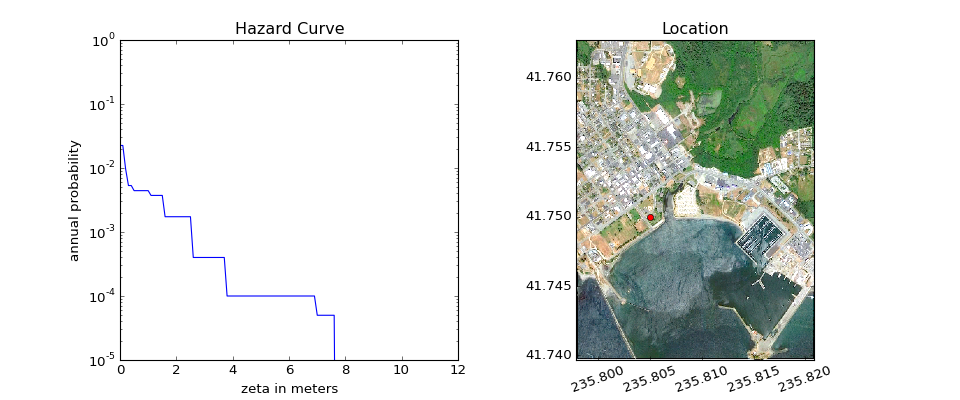

-c:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1057: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/Users/rjl/anaconda/envs/jupyter/lib/python2.7/site-packages/matplotlib/axes/_base.py:1062: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


In [13]:
fig = plot_hcurve(235.805, 41.75)

### Version that allows clicking on a point

<IPython.core.display.Javascript object>


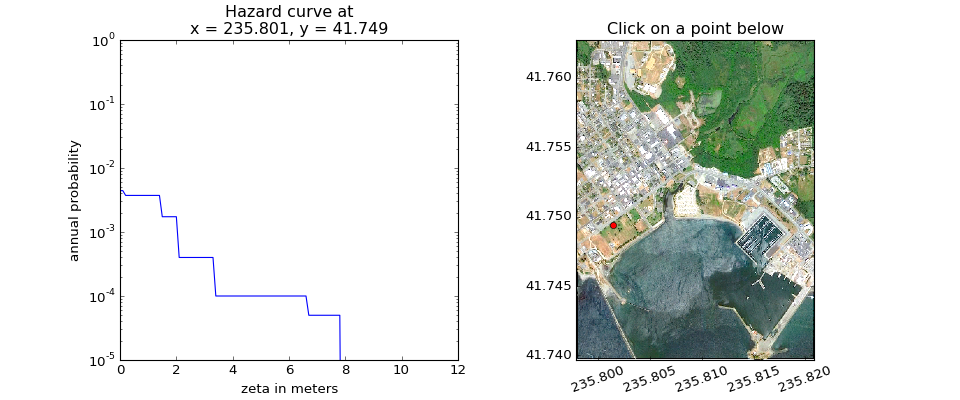

-c:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [14]:
dx = X[1,0] - X[0,0]
dy = Y[0,1] - Y[0,0]
nx, ny = X.shape
xmin = X.min(); xmax = X.max()
ymin = Y.min(); ymax = Y.max()

xmean = X.mean()
ymean = Y.mean()

def p_haz_curve(longitude,latitude):
    i = (longitude - X[0,0]) / dx
    j = (latitude - Y[0,0]) / dy
    if (i<0) or (i>=nx) or (j<0) or (j>=ny):
        print "out of domain"
    p = maximum(exceed_prob[i,j,:], 1e-10)
    return p
    
fig = figure(figsize=(12,5))
ax1 = subplot(1,2,1)
p = p_haz_curve(xmean, ymean)
line = semilogy(zeta, p, 'b')
ylim(1e-5,1)
xlabel('zeta in meters')
ylabel('annual probability')
title('Hazard Curve')

# Also plot the CC image with a red dot showing the location:
ax2 = subplot(1,2,2)
imshow(CCmap,extent=extent)
CClatitude = 41.75  # to rescale longitude
ax2.set_aspect(1. / cos(pi*CClatitude/180.)) 
ax2.ticklabel_format(format='plain',useOffset=False)
xticks(rotation=20)
point = ax2.plot([xmean], [ymean], 'ro')
xlim(xmin,xmax)
ylim(ymin,ymax)
title("Click on a point below")
      
def onclick(event):
    point[0].set_data([[event.xdata],[event.ydata]])
    line[0].set_data([zeta, p_haz_curve(event.xdata, event.ydata)])
    ax1.set_title("Hazard curve at \nx = %6.3f, y = %6.3f" % (event.xdata, event.ydata))
    draw()
    

cid = fig.canvas.mpl_connect('button_press_event', onclick)

### Interactive viewer to move the point around:

The `interact_manual` command used below is used in the same way as `interact` but does not create or refresh the plot until the `Run plot_hcurve` button is pressed.  This may be desirable if refreshing happens too slowly as the slider is dragged with `interact`.  (Try either in the cell below to compare the behavior.)

<IPython.core.display.Javascript object>


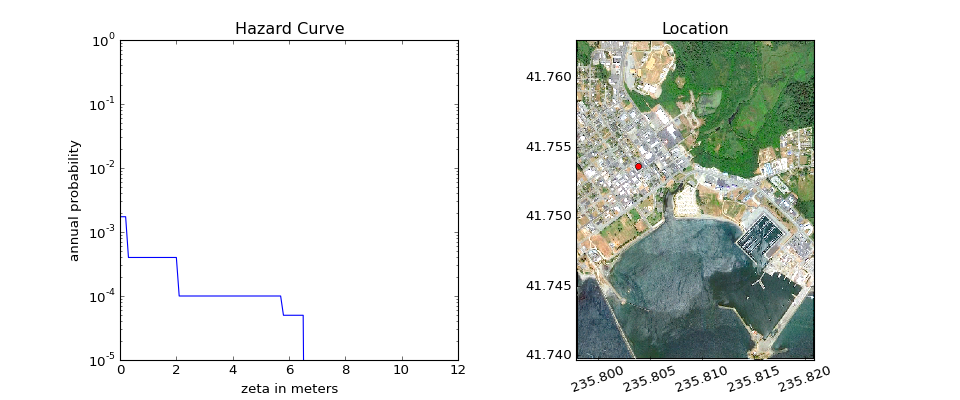

-c:15: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
interact_manual(plot_hcurve, longitude=(xmin,xmax,.001),latitude=(ymin,ymax,0.001))